In [1]:
using CairoMakie
using Printf
using JLD2
using FourierFlows

using LinearAlgebra: ldiv!, mul!
include("AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
function linear_array_index(x, x_min, x_max, Nbins)
    return max(min(floor(Int, (x-x_min)/(x_max - x_min) * Nbins)+1, Nbins), 1)
end

function exponential_array_index(x, x_min, x_max, Nbins)
    return min(floor(Int, log(x/x_min) / log(x_max / x_min) * Nbins)+1, Nbins)
end

function count_bins(x, index_function, bin_counts)
    bin_idx = index_function.(x)
    @views bin_counts[bin_idx] .+= 1
    return bin_counts
end

function snapshot_counts(directory, dissipation_threshold, transform_function, Nbins, index_function, snap_idx)
    t, x, k, u = load_snapshot(directory, snap_idx)
    bin_counts = zeros(Nbins)
    ω = transform_function(k)
    return count_bins(ω[ω .<= dissipation_threshold], index_function, bin_counts), t
end

function total_wave_energy(k, dispersion_relation)
    ω = dispersion_relation(k)
    return sum(ω[isfinite.(ω)])
end

function total_energy(directory, Npackets, dispersion_relation)
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    total_snapshots = count_snapshots(directory, num_files)
    times = zeros(total_snapshots)
    energy = zeros(total_snapshots)
    snap_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        for snapshot=keys(file["p/t"])
        
            times[snap_idx] =  file["p/t/" * snapshot]
            energy[snap_idx] =  total_wave_energy(file["p/k/" * snapshot], dispersion_relation)
            snap_idx += 1
        end
        close(file)
    end
    return times, energy
end

function timewise_counts(directory, Npackets, dissipation_threshold, transform_function, Nbins, index_function, idx_limit)
    have_been_dissipated = falses(Npackets)
    latest_t = 0
    bin_counts = zeros(Nbins)
    total_snapshots = 0
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        for snapshot=keys(file["p/t"])
            if(total_snapshots >= idx_limit)
                break
            end
            latest_t =  file["p/t/" * snapshot]
            k =  file["p/k/" * snapshot]
            ω = transform_function(k)
            have_been_dissipated .|= (ω .>= dissipation_threshold)

            bin_idx = index_function.(ω[.~have_been_dissipated])
            @views bin_counts[bin_idx] .+= 1#exp(-1e-3 * latest_t)
            total_snapshots += 1
        end
        close(file)
    end
    return bin_counts, total_snapshots, latest_t, have_been_dissipated
end

function true_snapshot_counts(directory, Npackets, dissipation_threshold, transform_function, Nbins, index_function, snap_idx)
    have_been_dissipated = falses(Npackets)
    latest_t = 0
    bin_counts = zeros(Nbins)
    total_snapshots = 0
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        for snapshot=keys(file["p/t"])
            if(total_snapshots >= snap_idx)
                break
            end
            latest_t =  file["p/t/" * snapshot]
            k =  file["p/k/" * snapshot]
            ω = transform_function(k)
            have_been_dissipated .|= (ω .>= dissipation_threshold)

            bin_idx = index_function.(ω[.~have_been_dissipated])
            total_snapshots += 1
        end
        close(file)
    end
    t, x, k, u = load_snapshot(directory, snap_idx)
    bin_counts = zeros(Nbins)
    ω = transform_function(k)
    return count_bins(ω[.~have_been_dissipated], index_function, bin_counts), t
end

true_snapshot_counts (generic function with 1 method)

In [3]:
using SpecialFunctions: erfc

function ω2k(ω, f0, Cg)
    return @. sqrt(ω^2 - f0^2)/Cg
end

function theoretical_action_spectrum(k, k0, kmax, b, t, f0, Cg)
    source_term = @. exp(-log(k/k0)^2/(4*b*t))
    diss_term = @. exp(-log(k*k0/kmax^2)^2/(4*b*t))
    action_spectrum = @. 1/sqrt(4π*b*t)*exp(-b*t) * (source_term - diss_term)
end

function g(k, t)
    return @. erfc((2*t-log(k))/(2*sqrt(t)))
end

function theoretical_forced_action_spectrum(k, k0, kmax, b, t, f0, Cg)
    term1 = @. k^2  * k0^2   * g(kmax^2/k/k0, 2*b*t)
    term2 = @.        kmax^4 * g(k*k0/kmax^2, 2*b*t)
    term3 = @. k^2  * kmax^2 * g(k0/k, 2*b*t)
    term4 = @. k0^2 * kmax^2 * g(k/k0, 2*b*t)
    return (term1 + term2 - term3 - term4)./(4*b*k*k0*kmax^2)
end

theoretical_forced_action_spectrum (generic function with 1 method)

In [6]:
run_idx = 7
#data_directory = "/scratch/nad9961/swqg/58628043/"# Long run with 16x as many packets
#data_directory = "/scratch/nad9961/swqg_rays/58489830/"
#data_directory = "/scratch/nad9961/swqg/58031124/" # Long run at low Froude number, yeah this is way too low
#data_directory = "/scratch/nad9961/swqg/58025661/" # Long run with no cutoff wavenumber
#data_directory = "/scratch/nad9961/twolayer_rays/59310910/" # Two Layer Phillips instability
#data_directory = "/scratch/nad9961/swqg/59389740/" # One Layer run with maybe longer time and a bug fix (Use run_idx = 7) (*)
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
#data_directory = "/scratch/nad9961/swqg/58025661/" # This matches the energetics of the two layer flow hopefully (Use run_idx = 20)
# data_directory = "/scratch/nad9961/swqg/60030992/" # This is a stronger background flow than case (*) (Use run_idx = 7)
data_directory = "/scratch/nad9961/swqg/60112713/" # Run idx 7
#data_directory = "/scratch/nad9961/twolayer_rays/60030361" # Another two-layer run with weaker background flow

#data_directory = "/scratch/nad9961/swqg/60281458/" # Run with amplitude between the really low and really high cases (run_idx = 7)

#data_directory = "/scratch/nad9961/swqg/60370119/" # Using 5 different strength of background flow amplitudes (run_idx = 1-5)
#data_directory = "/scratch/nad9961/swqg/60517726/" # Using 4 different strength of background flow amplitudes (run_idx = 1-5)
#data_directory = "/scratch/nad9961/swqg/60557304/" # Same as above, different numbers

#data_directory = "/scratch/nad9961/swqg/60595660/" # Running 5x longer, testing amplitude, 4 orders of magnitude
#data_directory = "/scratch/nad9961/swqg/64958835/" # Idk I just ran it a long time (run_idx = 1)
#data_directory = "/scratch/nad9961/swqg/64977428/" # Run with rays at different background velocities

run_directory = data_directory * string(run_idx)
Nsnapshots = count_snapshots(run_directory)
f0, Cg = read_parameters(run_directory)

radial_transform_function(k) = sqrt.(sum(k.^2, dims=2))
dispersion_transform_function(k) = compute_ω(k, f0, Cg)

t, _, k, _ = initial_packets = load_snapshot(run_directory, 1)
Npackets = size(k,1)
println(Npackets)

times, energy = total_energy(run_directory, Npackets, dispersion_transform_function)

262144


([0.0, 409.706298828125, 410.69781494140625, 411.6893310546875, 412.68084716796875, 413.67236328125, 414.66387939453125, 415.6553955078125, 416.64691162109375, 417.638427734375  …  28837.2734375, 28838.38671875, 28839.5, 28840.61328125, 28841.7265625, 28842.83984375, 28843.953125, 28845.06640625, 28846.1796875, 28847.29296875], [1.1121828003574768e6, 1.1349106826310512e6, 1.1491942375287204e6, 1.1537706501072627e6, 1.163555169571261e6, 1.1725257503565107e6, 1.170680497128701e6, 1.1667273980611255e6, 1.1652405100653395e6, 1.1633546023757202e6  …  1.8986503535757495e15, 2.59592128277677e15, 3.512221189366489e15, 4.703652683435649e15, 6.156032999266395e15, 8.488485725666968e15, 1.1840104112705114e16, 1.642575936598998e16, 2.3451253674789068e16, 3.3502491180597776e16])

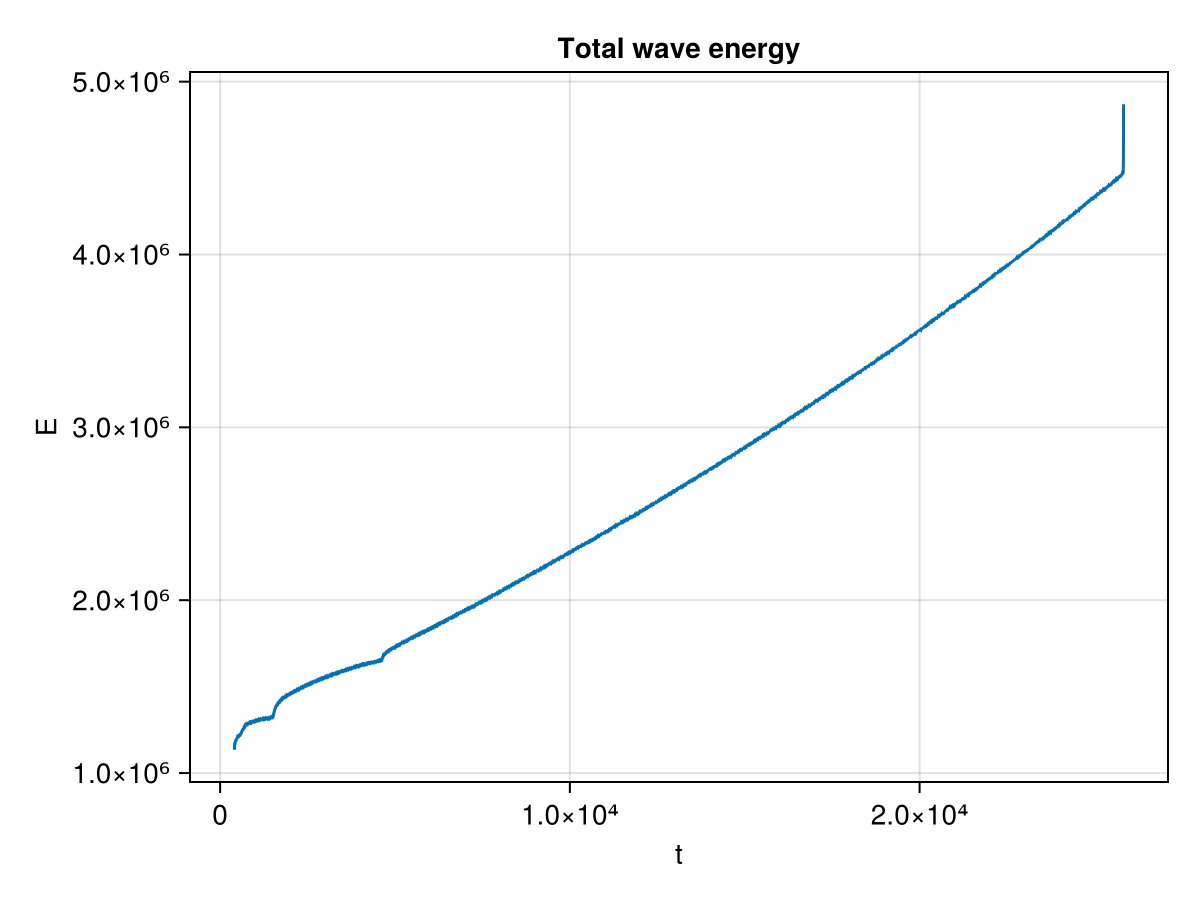

In [8]:
fig = Figure()
ax = Axis(fig[1,1], title = "Total wave energy", xlabel="t", ylabel="E")#, xscale=log10, yscale=log10)

filter = @. ~isnan(energy) & (energy < Inf)
filter[1] = false
lines!(ax, times[2:23290], energy[2:23290])

fig

In [7]:
isfinite(NaN)

false

In [7]:
ω_min = f0
k_min = 0.1
k0 = 3
ω_max = 1000*f0
k_max = sqrt(ω_max^2 - f0^2)/Cg

K_D = f0/Cg

Nbins = 8000
#bin_edges = @. exp(log(ω_min) + (log(ω_max/ω_min)*(0:(Nbins-1))/(Nbins-1)))
#bin_size = diff(exp.((0:(Nbins))/Nbins * log(ω_max / ω_min) ) * ω_min)
#index_function(ω) = exponential_array_index(ω, ω_min, ω_max, Nbins)

bin_edges = @. ω_min .+ (ω_max - ω_min) * (0:Nbins)/Nbins
bin_size = 1/Nbins
bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
ω_index_function(x) = linear_array_index(x, ω_min, ω_max, Nbins)
K_index_function(x) = linear_array_index(x, k_min, k_max, Nbins)

max_snap_idx = count_snapshots(run_directory)
#forced_bin_counts, total_snapshots, latest_t, have_been_dissipated = timewise_counts(run_directory, Npackets, ω_max, dispersion_transform_function, Nbins, ω_index_function, max_snap_idx)
bin_counts, time = snapshot_counts(run_directory, ω_max, dispersion_transform_function, Nbins, ω_index_function, max_snap_idx)

([2297.0, 7422.0, 12715.0, 14334.0, 11589.0, 7578.0, 4343.0, 2458.0, 1300.0, 660.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 11098.066f0)

In [8]:
using LsqFit

function find_best_b_fit(x, y, model, p0)
    fit = curve_fit(model, x, y, p0)
    return fit
end

function theo_free_decay_spectrum(k, p)
    τ = exp(p[2])
    result = exp.(-log.(k/k0).^2/(4*τ))
    result /= sum(result)
    #println(log.(result))
    return log.(result)
end

best_fit_func(k, p) = log.(p[1]*theoretical_action_spectrum(k, k0, k_max, max(p[2], 1e-19), 1, f0, Cg))

norm_bin_counts = nothing
nan_filter = nothing
fit = nothing
times = zeros(max_snap_idx)
tau_params = zeros(max_snap_idx)
array_idx = 1
for snap_idx=1:max_snap_idx
    bin_counts, time = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, snap_idx)
    norm_bin_counts = bin_counts / sum(bin_counts)
    nan_filter = ((bin_counts .>= 1) .& (bin_centers .>= k0))
    fit = find_best_b_fit(bin_centers[nan_filter], log.(norm_bin_counts[nan_filter]), theo_free_decay_spectrum, [1, -1.0])
    tau_params[array_idx] = exp(fit.param[2])
    times[array_idx] = time
    array_idx += 1
end

LoadError: UndefVarError: `index_function` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

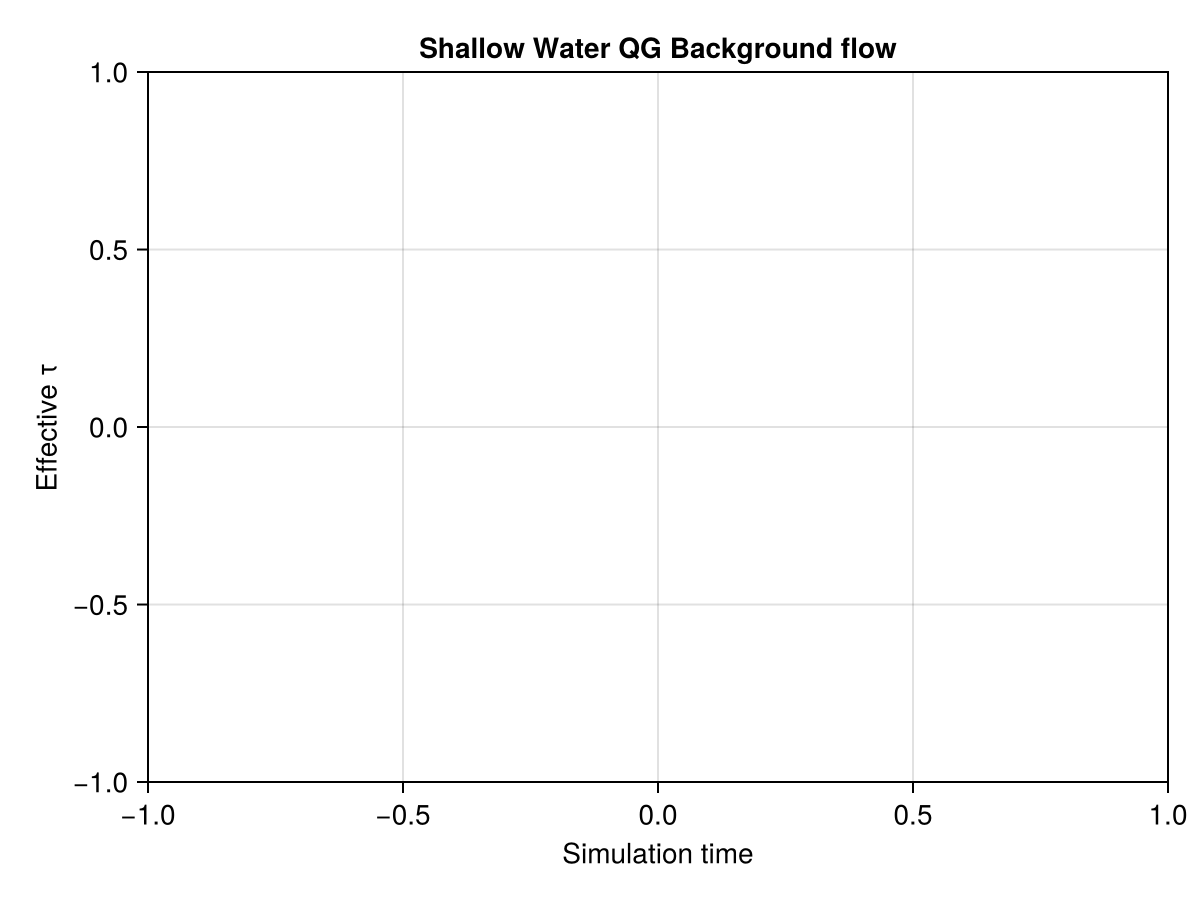

In [10]:
fig = Figure()
ax = Axis(fig[1,1], title="Shallow Water QG Background flow", xlabel="Simulation time", ylabel="Effective τ")
lines!(ax, times[1:end-3], tau_params[1:end-3])
#lines!(ax, times[1:end-2], 1.25e-5 * (times[1:end-2]), label="b = 1.3e-5")
#axislegend(ax, position=:rb)
fig

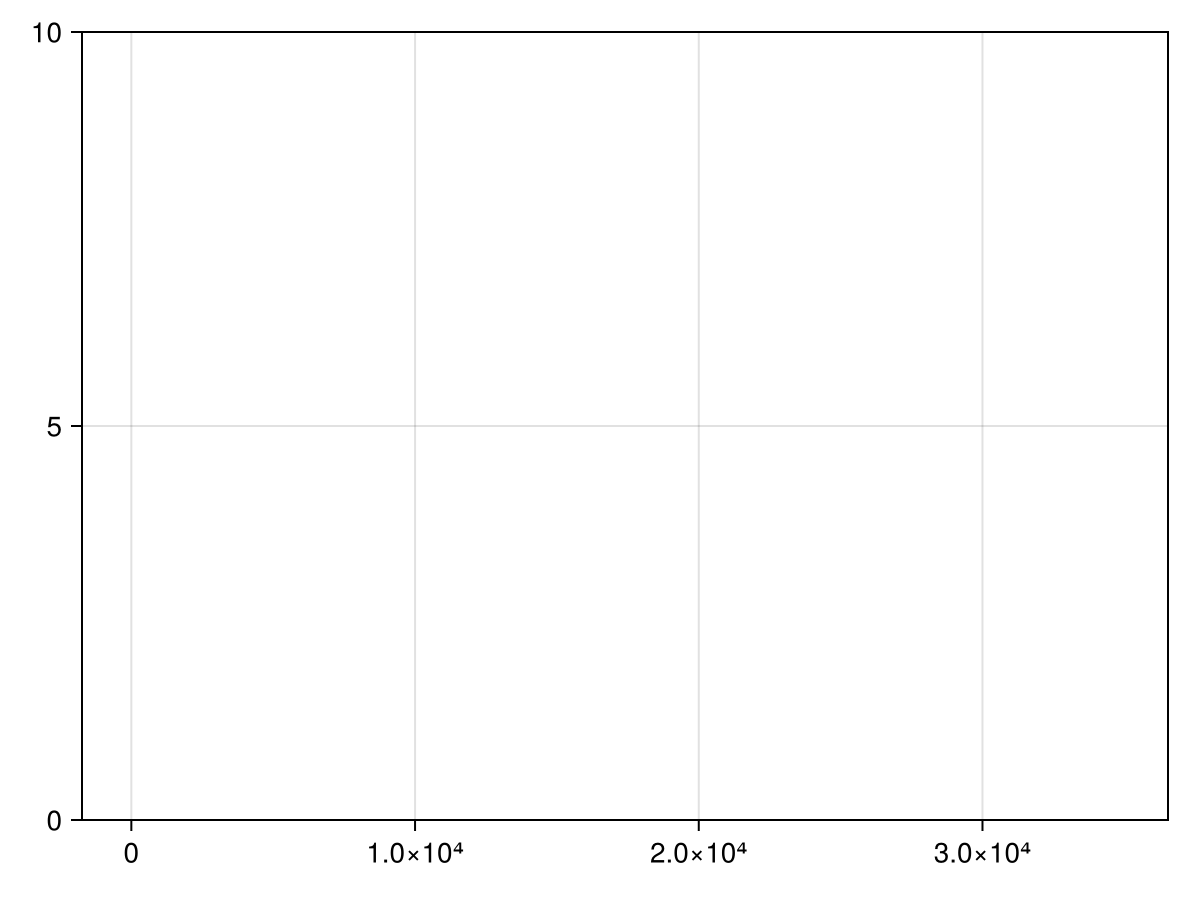

In [11]:
t_offset, _, _, u = load_snapshot(run_directory, 2)
lines((tau_params .- 1.25e-5 * (times .- t_offset)) ./ sum(tau_params) * length(tau_params))

In [12]:
1.25e-5 * t_offset

0.06222156982421875

In [13]:
sum(tau_params) / length(tau_params)

0.0

In [14]:
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((1, k_max), (1e-9, 1e0)))

lines!(ax, bin_centers, norm_bin_counts)
lines!(ax, bin_centers, exp.(theo_free_decay_spectrum(bin_centers, [1, fit.param[2]])))

fig

LoadError: ArgumentError:     Conversion failed for Lines (With conversion trait PointBased()) with args: Tuple{Vector{Float64}, Nothing} .
    Lines requires to convert to argument types Tuple{AbstractVector{<:Union{Point2, Point3}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Lines or PointBased() and return an object of type Tuple{AbstractVector{<:Union{Point2, Point3}}}.`


In [15]:
N_bins = 8000
_, _, k, uf = load_snapshot(run_directory, Nsnapshots-1)
bin_counts = zeros(N_bins)
K = radial_transform_function(k)
#count_bins(K[K .<= k_max], index_function, bin_counts)
K[K .<= k_max]
mean(sqrt.(sum(uf.^2, dims=2)))

0.052959524f0

In [9]:
function smoothing_function(x, N)
    moving_average_fn(i) = sum(@views(x[i-N:i+N]))/(2*N + 1)
    smooth_data = map(moving_average_fn, (N+1):(length(x)-N))
    return vcat(x[1:N], smooth_data, x[end-N+1:end])
end

smoothing_function (generic function with 1 method)

2404
f0 = 3.0
Cg = 1.0
0.7517151563153981
2985.689
2985.689
2985.689


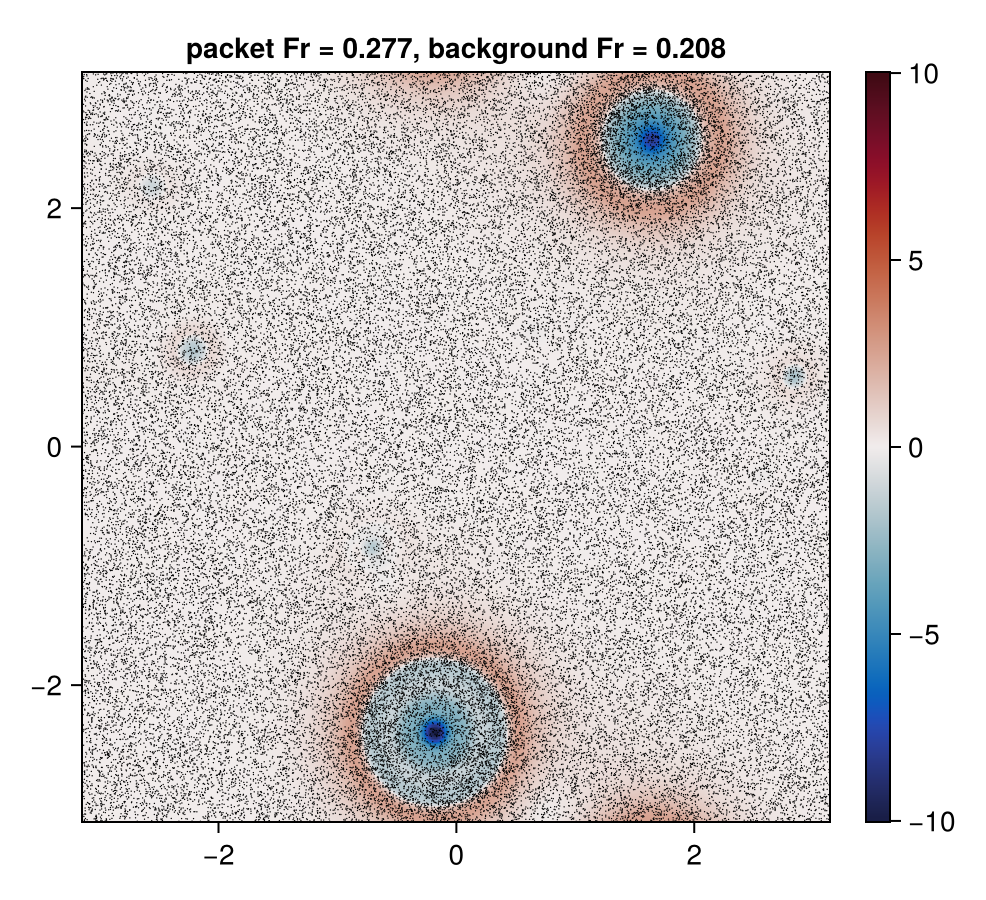

In [30]:
run_idx = 3
#data_directory = "/scratch/nad9961/swqg/58628043/"# Long run with 16x as many packets
#data_directory = "/scratch/nad9961/swqg_rays/58489830/"
#data_directory = "/scratch/nad9961/swqg/58031124/" # Long run at low Froude number, yeah this is way too low
#data_directory = "/scratch/nad9961/swqg/58025661/" # Long run with no cutoff wavenumber
#data_directory = "/scratch/nad9961/twolayer_rays/59310910/" # Two Layer Phillips instability
#data_directory = "/scratch/nad9961/swqg/59389740/" # One Layer run with maybe longer time and a bug fix (Use run_idx = 7) (*)
#data_directory = "/scratch/nad9961/swqg/57478238/"
#data_directory = "/scratch/nad9961/swqg/57233897/" # Matches RSW run 57233890
#data_directory = "/scratch/nad9961/swqg/58025661/" # This matches the energetics of the two layer flow hopefully (Use run_idx = 20)
#data_directory = "/scratch/nad9961/swqg/60030992/" # This is a stronger background flow than case (*) (Use run_idx = 7)
#data_directory = "/scratch/nad9961/twolayer_rays/60030361" # Another two-layer run with weaker background flow

#data_directory = "/scratch/nad9961/swqg/60112713/" # Run idx 7, I missed this one

#data_directory = "/scratch/nad9961/swqg/60281458/" # Run with amplitude between the really low and really high cases (run_idx = 7)

#data_directory = "/scratch/nad9961/swqg/60370119/" # Using 5 different strength of background flow amplitudes (run_idx = 1-5)
#data_directory = "/scratch/nad9961/swqg/60517726/" # Using 4 different strength of background flow amplitudes (run_idx = 1-5)
#data_directory = "/scratch/nad9961/swqg/60557304/" # Same as above, different numbers

#data_directory = "/scratch/nad9961/swqg/60595660/" # Running 5x longer, testing amplitude, 4 orders of magnitude
#data_directory = "/scratch/nad9961/swqg/64958835/" # Idk I just ran it a long time (run_idx = 1)
#data_directory = "/scratch/nad9961/swqg/64977428/" # Run with rays at different background velocities
# data_directory = "/scratch/nad9961/rsw_ray/66603117/" # Run with RSW background flow
data_directory = "/scratch/nad9961/swqg/275197/"


run_directory = data_directory * string(run_idx)
Nsnapshots = count_snapshots(run_directory)
println(Nsnapshots)
f0, Cg = read_parameters(run_directory)
ω_min = f0
println("f0 = ", f0)
Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
println("Cg = ", Cg)

snap_idx = floor(Int, Nsnapshots)

#params = load_2L_qg_params(run_directory)
t1, x, k, uf = load_snapshot(run_directory, snap_idx)
Npackets = size(k, 1)
# x = x[.~any(isnan.(k), dims=2)[:], :]
grid = TwoDGrid(;nx=512, Lx=2π)
t2, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
_, _, ψh, _, _, _ = load_qgswh_snapshot(run_directory, grid, Nqg_snapshots)
σs, σn, σ, ζ = compute_strain_vorticity(ψh)

D = σ.^2 - ζ.^2
D = @. sign(D) * sqrt.(abs(D))
umax = maximum(sqrt.(u.^2 + v.^2))
println(umax)
println(t2)
#t2, qh, ψh = load_2L_snapshot(run_directory, grid, params, 683)
#qth = @views qh[:,:,1] + qh[:,:,2]
#ψth = @views ψh[:,:,1] + ψh[:,:,2]
#uh = -1im * grid.l  .* ψth
#vh =  1im * grid.kr .* ψth

#q = irfft(qth, grid.nx)
#u = irfft(uh, grid.nx)
#v = irfft(vh, grid.nx)
x = @. mod(x + π, 2π) - π

packet_u_rms = sqrt.(sum(uf.^2) / size(x,1))
background_u_rms = sqrt.(sum(u.^2 + v.^2) / (grid.nx * grid.ny))
fig = Figure()
ax = Axis(fig[1,1]; title=@sprintf("packet Fr = %0.3f, background Fr = %0.3f", packet_u_rms / Cg, background_u_rms / Cg))

num_points = 256^2
cmax = maximum(abs.(D))
hm = heatmap!(ax, grid.x, grid.y, D, colormap=:balance, colorrange = (-cmax, cmax))
Colorbar(fig[1,2], hm)
scatter!(ax, x[1:num_points,1], x[1:num_points,2], color=:black, markersize=1)

println(t1)
println(t2)
colsize!(fig.layout, 1, Aspect(1.0, 1))
resize_to_layout!(fig)
save("images/test_image_"*string(run_idx)*".png", fig)
fig

2404


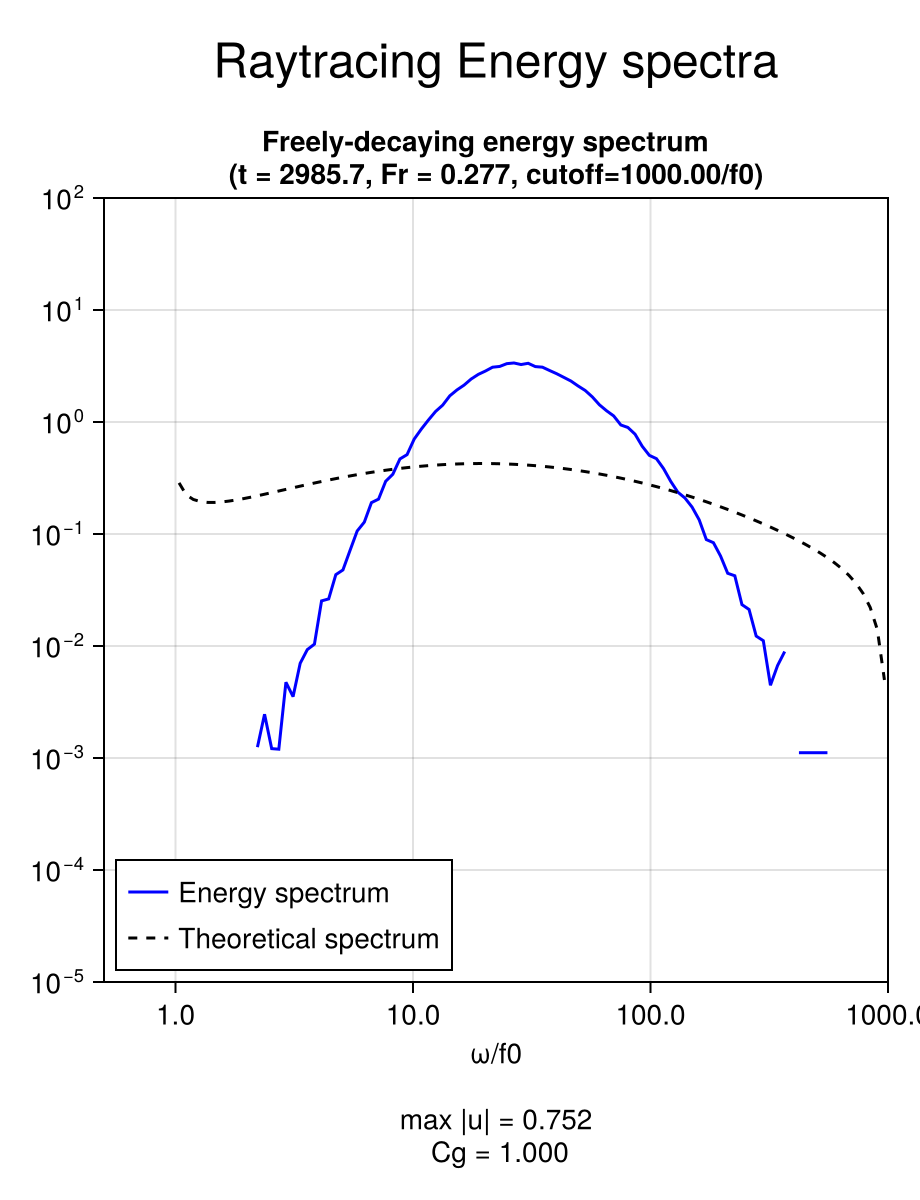

In [31]:
normalize(data) = data / sum(data)

t_offset, _, _, _ = load_snapshot(run_directory, 2)

snap_idx = floor(Int, Nsnapshots)
println(snap_idx)

ω_max = f0*1000
Nbins = 100
bin_edges = @. exp(log(ω_min) + (log(ω_max/ω_min)*(0:(Nbins))/(Nbins)))
bin_size = diff(exp.((0:(Nbins))/Nbins * log(ω_max / ω_min) ) * ω_min)
bin_centers = @. sqrt(bin_edges[1:end-1] .* bin_edges[2:end])
ω_index_function(ω) = exponential_array_index(ω, ω_min, ω_max, Nbins)
K_index_function(ω) = exponential_array_index(k, k_min, k_max, Nbins)

#bin_edges = @. ω_min .+ (ω_max - ω_min) * (0:Nbins)/Nbins
#bin_size = 1/Nbins
#bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
#ω_index_function(ω) = linear_array_index(ω, ω_min, ω_max, Nbins)
#K_index_function(ω) = linear_array_index(k, k_min, k_max, Nbins)


bin_counts, time = snapshot_counts(run_directory, ω_max, dispersion_transform_function, Nbins, ω_index_function, snap_idx)
#bin_counts, time = true_snapshot_counts(run_directory, Npackets, ω_max, dispersion_transform_function, Nbins, ω_index_function, snap_idx)
forced_bin_counts, total_snapshots, latest_t, have_been_dissipated = timewise_counts(run_directory, Npackets, ω_max, dispersion_transform_function, Nbins, ω_index_function, 10)
bin_counts ./= bin_size
forced_bin_counts ./= bin_size

_, _, _, uf = load_snapshot(run_directory, snap_idx)
u_rms = sqrt.(sum(uf.^2)/Npackets)

Fr = u_rms / Cg

dissipated_fraction = sum(have_been_dissipated)/length(have_been_dissipated)

fig1 = Figure(size=(800, 600))
fig2 = Figure(size=(600, 600))
axis_options = (; xscale=log10, yscale=log10, xticks=([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]), xlabel="ω/f0", limits=((0.5, ω_max / f0), (1e-5, 1e2)))
Label(fig1[0,1], "Raytracing Energy spectra", fontsize=24)
Label(fig2[0,1], "Raytracing Energy spectra", fontsize=24)
ax_forced = Axis(fig2[1,1]; title=@sprintf("Forced-dissipative energy spectrum \r\n(t = %0.1f, Fr = %0.3f, cutoff=%0.2f/f0, diss=%0.2f%%)", latest_t, Fr, ω_max/f0, 100*dissipated_fraction), axis_options...)
ax_snap = Axis(fig1[1,1]; title=@sprintf("Freely-decaying energy spectrum \r\n(t = %0.1f, Fr = %0.3f, cutoff=%0.2f/f0)", time, Fr, ω_max/f0), axis_options...)

#forced_action_spectrum = replace(forced_bin_counts, 0 => NaN) / Npackets ./ bin_size / total_snapshots
forced_action_spectrum = replace(normalize(forced_bin_counts), 0 => NaN)# * (1e-3 / (1 + exp(-1e-3 * time)))
action_spectrum = replace(normalize(bin_counts), 0 => NaN)
#lin_action_spectrum = replace(lin_bin_counts, 0 => NaN) / total_snapshots / Npackets  / ((ω_max - ω_min) / Nbins)

radial_action_spectrum = action_spectrum
radial_forced_action_spectrum = forced_action_spectrum

k0 = 3
ω0 = compute_ω([k0;; 0], f0, Cg)[1]
k_max = sqrt(ω_max^2 - f0^2)/Cg 
b0 = exp(0.4)
b_fd = exp(0.6721778342094137)
ks = @. sqrt(bin_centers^2 - f0^2)/Cg
conversion_factor = @. bin_centers / (Cg^2 * ks)
ωs = bin_centers

theo_action = theoretical_action_spectrum(ks, k0, k_max, b0, 1, f0, Cg)
theo_action[theo_action .<= 0] .= NaN
theo_action = normalize(theo_action)

theo_fd_action = theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, 1, f0, Cg) - theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, 1e-9, f0, Cg)
theo_fd_action[theo_fd_action .<= 0] .= NaN
theo_fd_action = normalize(theo_fd_action)

radial_energy = ωs .* radial_action_spectrum .* conversion_factor
radial_forced_energy = ωs .* radial_forced_action_spectrum .* conversion_factor

theo_energy = ωs .* theo_action .* conversion_factor
theo_fd_energy = ωs .* theo_fd_action .* conversion_factor

lines!(ax_snap, ωs/f0, radial_energy, color="blue", label="Energy spectrum")
lines!(ax_forced, ωs/f0, radial_forced_energy, color="red", label="Energy spectrum")

lines!(ax_snap, ωs/f0, theo_energy, color="black", linestyle=:dash, label="Theoretical spectrum")
lines!(ax_forced, ωs/f0, theo_fd_energy, color="black", linestyle=:dot, label="Theoretical spectrum")

Label(fig1[2,1], @sprintf("max |u| = %0.3f\n Cg = %0.3f", umax, Cg))

axislegend(ax_snap, position=:lb)
axislegend(ax_forced, position=:lb)
colsize!(fig1.layout, 1, Aspect(1.0, 1))
colsize!(fig2.layout, 1, Aspect(1.0, 1))
resize_to_layout!(fig1)
resize_to_layout!(fig2)
fig1

In [21]:
test_file = jldopen("/scratch/nad9961/swqg/275197/1/packets.000000.jld2")
println(test_file["p/k/0"])
close(test_file)

Float32[60.0 0.005752428; 60.0 0.011504856; 59.999996 0.017257284; 59.999996 0.023009712; 59.999992 0.02876214; 59.99999 0.034514565; 59.999985 0.040266994; 59.99998 0.04601942; 59.999977 0.051771846; 59.999973 0.05752427; 59.999966 0.06327669; 59.99996 0.06902912; 59.999954 0.074781545; 59.999947 0.08053397; 59.99994 0.08628639; 59.999928 0.09203881; 59.99992 0.09779123; 59.999912 0.103543654; 59.9999 0.10929607; 59.99989 0.11504849; 59.999878 0.120800905; 59.999866 0.12655333; 59.999855 0.13230574; 59.99984 0.13805816; 59.99983 0.14381056; 59.999813 0.14956297; 59.999798 0.15531538; 59.999783 0.16106778; 59.999767 0.1668202; 59.999752 0.1725726; 59.999737 0.178325; 59.999718 0.18407741; 59.9997 0.18982981; 59.99968 0.19558221; 59.99966 0.2013346; 59.99964 0.207087; 59.999622 0.2128394; 59.999603 0.21859178; 59.99958 0.22434416; 59.999557 0.23009655; 59.999535 0.23584893; 59.99951 0.24160132; 59.99949 0.2473537; 59.999466 0.2531061; 59.999443 0.25885844; 59.999416 0.26461083; 59.99939

Excessive output truncated after 524297 bytes.

-44.25175 40.518917; -44.255634 40.514675; -44.259518 40.51043; -44.2634 40.506187; -44.267284 40.50194; -44.271168 40.4977; -44.27505 40.493454; -44.278934 40.48921; -44.282814 40.484962; -44.286697 40.480717; -44.290577 40.47647; -44.294456 40.472225; -44.298336 40.46798; -44.302216 40.46373; -44.306095 40.459484; -44.309975 40.455235; -44.313854 40.45099; -44.31773 40.44674; -44.32161 40.44249; -44.325485 40.43824; -44.329365 40.43399; -44.33324 40.42974; -44.337116 40.42549; -44.340992 40.421238; -44.344868 40.41699; -44.34874 40.412735; -44.352615 40.40848; -44.356487 40.404232; -44.360363 40.39998; -44.364235 40.395725; -44.368107 40.39147; -44.37198 40.38722; -44.37585 40.382965; -44.379723 40.378708; -44.383595 40.374454; -44.387466 40.370197; -44.391335 40.365944; -44.395206 40.361687; -44.399075 40.35743; -44.402943 40.353172; -44.406815 40.348915; -44.410683 40.344658; -44.414547 40.3404; -44.418415 40.33614; -44.422283 40.331882; -44.42615 40.327625; -44.430016 40.323364; -

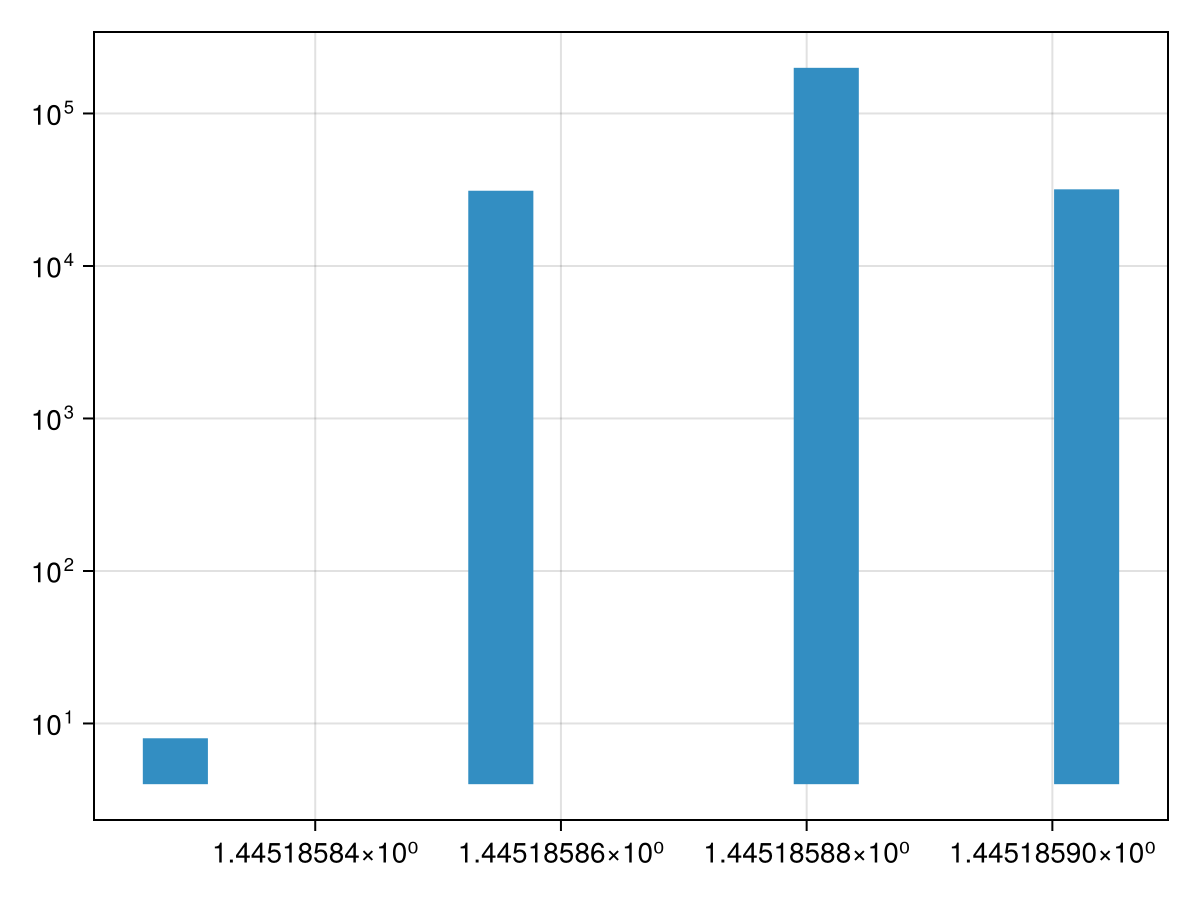

In [18]:
t, x, k, u = load_snapshot(run_directory, 1)
ω = compute_ω(k, f0, Cg)
hist(log.(ω[isfinite.(ω)]); axis=(; yscale=log10))

In [82]:
println(mean(sqrt.(sum(uf.^2, dims=2)[:])))
println(mean(sqrt.(u.^2 + v.^2)))
println(maximum(sqrt.(sum(uf.^2, dims=2)[:])))
println(maximum(sqrt.(u.^2 + v.^2)))
println("Cg = ", Cg)
println(sqrt.(sum(uf.^2)/Npackets))

0.13319428
0.07260459021833639
0.4467776
0.4471002965289753
Cg = 0.5
0.20635088


In [24]:
t, x, k, u = load_snapshot(run_directory, Nsnapshots)
ω = sqrt.(f0.^2 .+ Cg.^2 * sum(k.^2, dims=2))
using StatsBase
median(ω[isfinite.(ω)])
sqrt.(sum(u.^2)/Npackets)/Cg^2

0.17337836f0

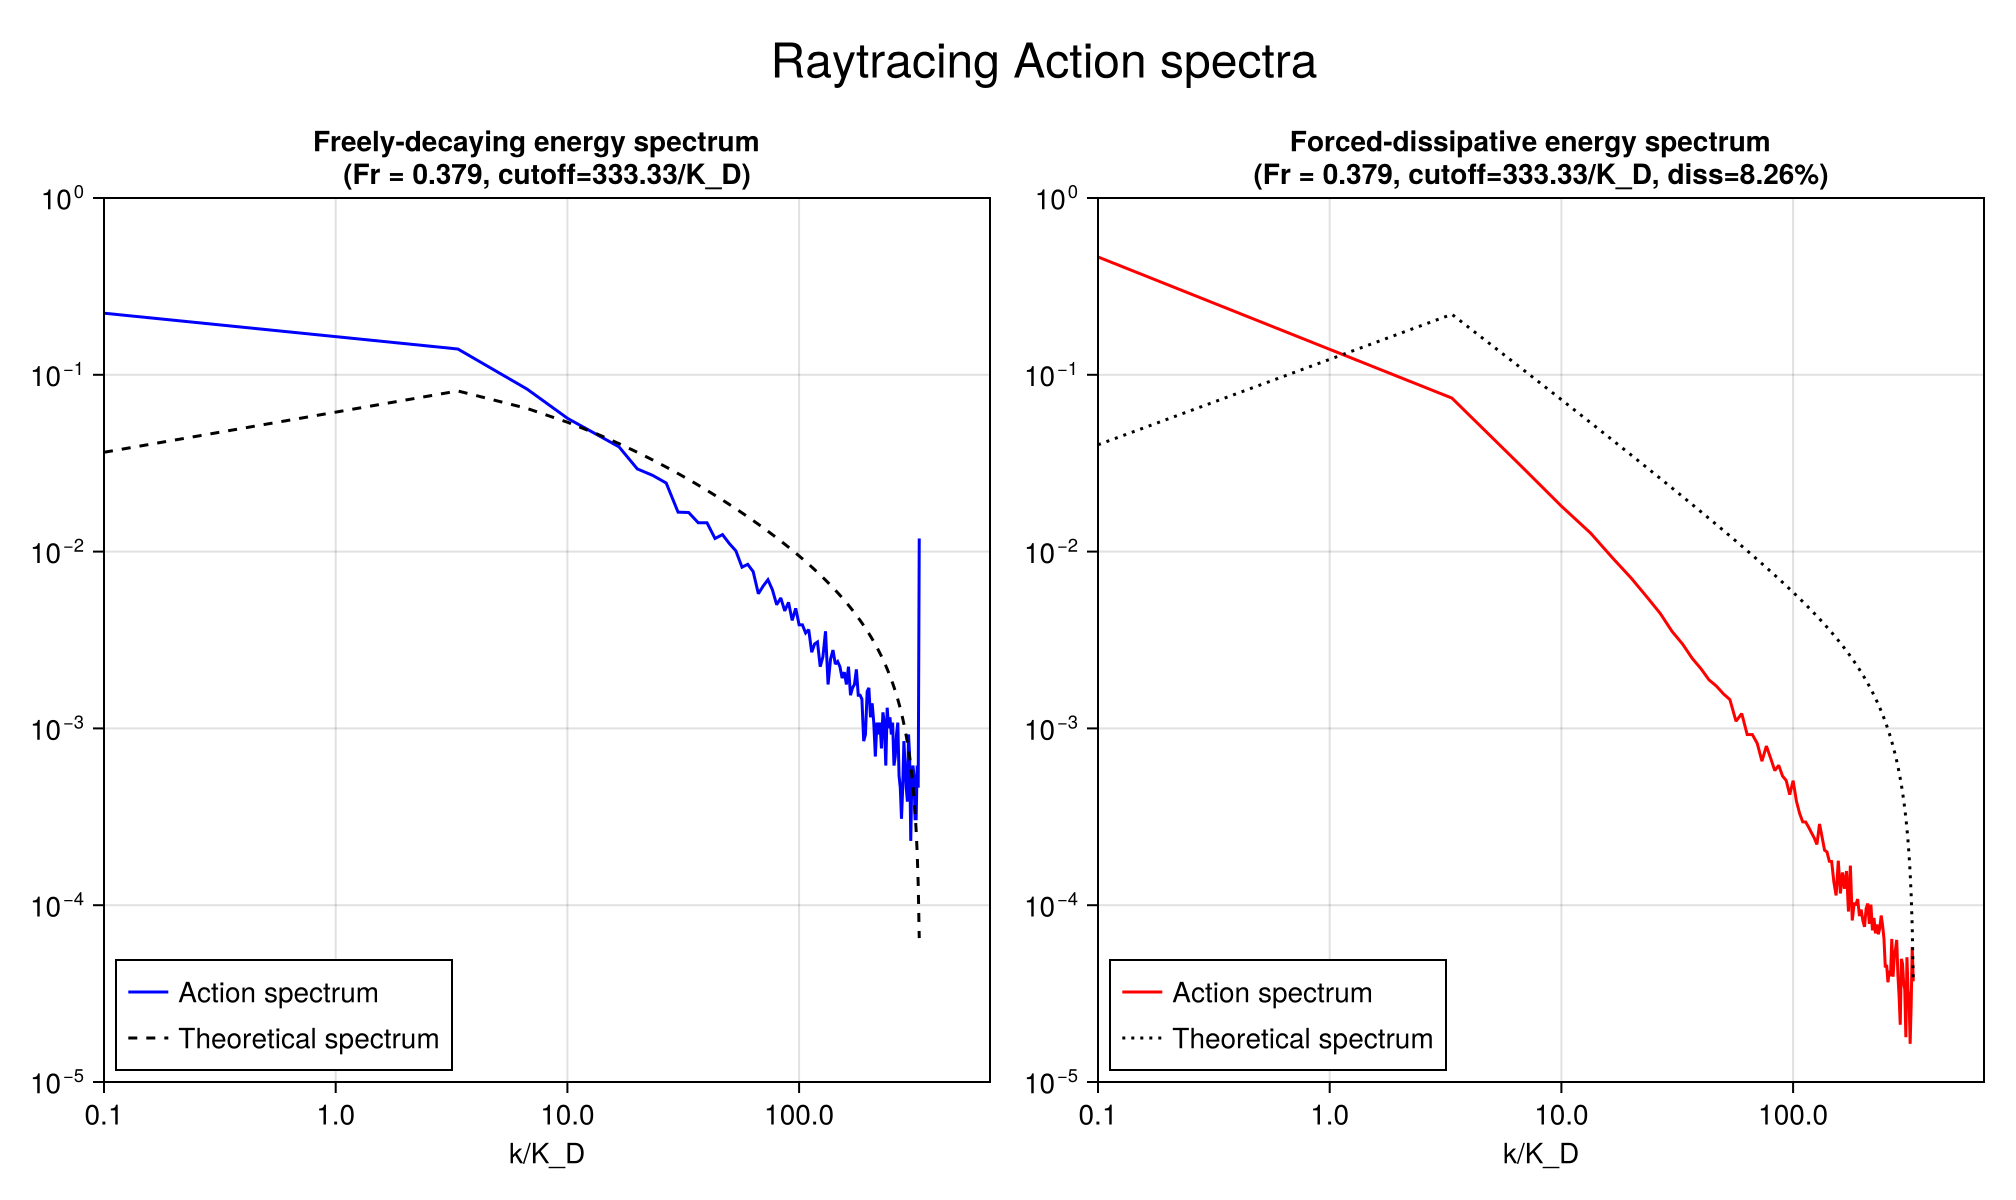

In [322]:
normalize(data) = data / sum(data)

t_offset, _, _, u = load_snapshot(run_directory, 2)

snap_idx = floor(Int, Nsnapshots)

k_max = 1000
Nbins = 100
#bin_edges = @. exp(log(ω_min) + (log(ω_max/ω_min)*(0:(Nbins))/(Nbins)))
#bin_size = diff(exp.((0:(Nbins))/Nbins * log(ω_max / ω_min) ) * ω_min)
bin_edges = @. k_min .+ (k_max - k_min) * (0:Nbins)/Nbins
bin_size = 1/Nbins
bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
ks = bin_centers
K_index_function(k) = linear_array_index(k, k_min, k_max, Nbins)

#bin_edges = @. ω_min .+ (ω_max - ω_min) * (0:Nbins)/Nbins
#bin_size = 1/Nbins
#bin_centers = bin_edges[1:end-1] .+ 0.5*bin_size
#ω_index_function(x) = linear_array_index(x, ω_min, ω_max, Nbins)

bin_counts, time = true_snapshot_counts(run_directory, Npackets, ω_max, dispersion_transform_function, Nbins, K_index_function, snap_idx)
forced_bin_counts, total_snapshots, latest_t, have_been_dissipated = timewise_counts(run_directory, Npackets, k_max, dispersion_transform_function, Nbins, K_index_function, 300)
bin_counts ./= bin_size
forced_bin_counts ./= bin_size

_, _, _, uf = load_snapshot(run_directory, snap_idx)
u_rms = sqrt.(sum(uf.^2)/Npackets)

Fr = u_rms / Cg

dissipated_fraction = sum(have_been_dissipated)/length(have_been_dissipated)

f = Figure(size=(1000, 600))
axis_options = (; xscale=log10, yscale=log10, xticks=([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]), xlabel="k/K_D", limits=((0.1, k_max / f0), (1e-5, 1e0)))
Label(f[0,1:2], "Raytracing Action spectra", fontsize=24)
ax_forced = Axis(f[1,2]; title=@sprintf("Forced-dissipative energy spectrum \r\n(Fr = %0.3f, cutoff=%0.2f/K_D, diss=%0.2f%%)", Fr, k_max/K_D, 100*dissipated_fraction), axis_options...)
ax_snap = Axis(f[1,1]; title=@sprintf("Freely-decaying energy spectrum \r\n(Fr = %0.3f, cutoff=%0.2f/K_D)", Fr, k_max/K_D), axis_options...)

#forced_action_spectrum = replace(forced_bin_counts, 0 => NaN) / Npackets ./ bin_size / total_snapshots
forced_action_spectrum = replace(normalize(forced_bin_counts), 0 => NaN)# * (1e-3 / (1 + exp(-1e-3 * time)))
action_spectrum = replace(normalize(bin_counts), 0 => NaN)
#lin_action_spectrum = replace(lin_bin_counts, 0 => NaN) / total_snapshots / Npackets  / ((ω_max - ω_min) / Nbins)

radial_action_spectrum = action_spectrum
radial_forced_action_spectrum = forced_action_spectrum

k0 = 3
b0 = exp(0.8560197997713443)
b_fd = exp(0.6721778342094137)
theo_action = theoretical_action_spectrum(ks, k0, k_max, b0, 1, f0, Cg)
theo_action[theo_action .<= 0] .= NaN
theo_action = normalize(theo_action)

theo_fd_action = theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, 1, f0, Cg) - theoretical_forced_action_spectrum(ks, k0, k_max, b_fd, 1e-9, f0, Cg)
theo_fd_action[theo_fd_action .<= 0] .= NaN
theo_fd_action = normalize(theo_fd_action)

lines!(ax_snap, bin_centers/K_D, radial_action_spectrum, color="blue", label="Action spectrum")
lines!(ax_forced, bin_centers/K_D, radial_forced_action_spectrum, color="red", label="Action spectrum")

lines!(ax_snap, bin_centers/K_D, theo_action, color="black", linestyle=:dash, label="Theoretical spectrum")
lines!(ax_forced, bin_centers/K_D, theo_fd_action, color="black", linestyle=:dot, label="Theoretical spectrum")


axislegend(ax_snap, position=:lb)
axislegend(ax_forced, position=:lb)
colsize!(f.layout, 1, Aspect(1.0, 1))
colsize!(f.layout, 2, Aspect(1.0, 1))
resize_to_layout!(f)
f

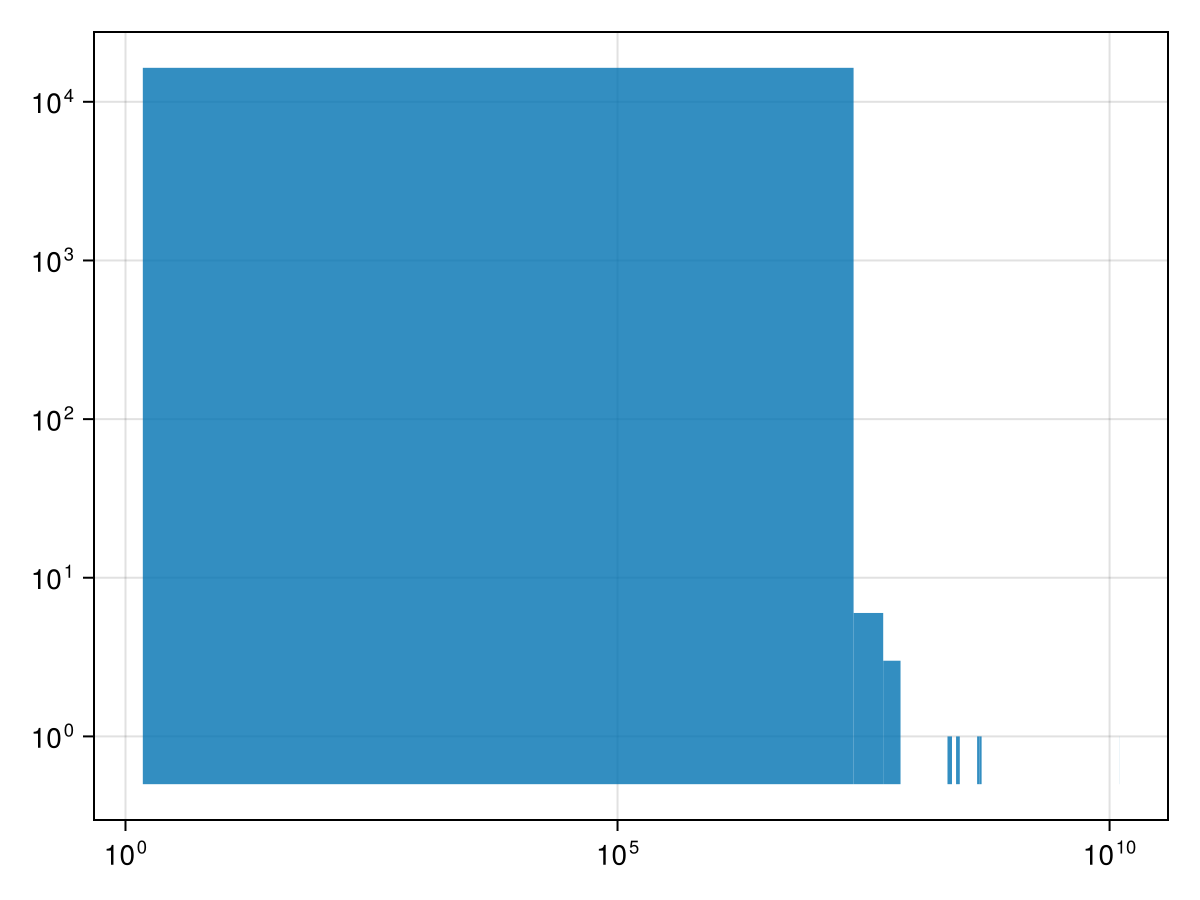

In [217]:
_, _, k, _ = load_snapshot(run_directory, snap_idx)
ω = dispersion_transform_function(k)
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10)
h = hist!(ax, ω, bins=500)

fig

In [215]:
h[1]

Observable([2.9341958329752655, 14.528209026504477, 2.2193096983903775, 6.5148892029222365, 6.587881391815253, 5.83976457687462, 0.4632968426814021, 1.4652357737580268, 4.787483367332124, 4.337435103893951  …  7.039381396726697, 7.8274518447689605, 8.054635425853375, 3.5453839608954616, 5.8462581718646, 5.687723548423653, 2.8902883456444117, 11.733484816831782, 5.086505313331015, 3.003626398930597])
    0 => map(pick_hist_edges(vals, bins) @ Makie /ext3/pkgs/packages/Makie/UjJJY/src/stats/hist.jl:149)


In [46]:
xs = map(x -> x[1], ecdf.axis.scene.plots[1].args[1][])
vals = map(x -> x[2], ecdf.axis.scene.plots[1].args[1][])
pdf = 0.00002 ./ diff(xs)
lines(pdf[2:end]; axis=(;xscale=log10, yscale=log10))

LoadError: UndefVarError: `ecdf` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing StatsBase in the current active module Main

In [323]:
using LsqFit

function find_best_b_fit(x, y, model, p0)
    fit = curve_fit(model, x, y, p0)
    return fit
end

k_bin_counts, time = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, K_index_function, snap_idx)
k_forced_bin_counts, total_snapshots, latest_t, have_been_dissipated = timewise_counts(run_directory, Npackets, k_max, radial_transform_function, Nbins, K_index_function, snap_idx)

normalize(data) = data / sum(data)
fit_time = latest_t

theo_energy_spectrum(k, p) = log.(normalize(theoretical_action_spectrum(k, k0, k_max, exp(p[1]), 1, f0, Cg)))
theo_fd_spectrum(k, p)     = log.(normalize(max.(theoretical_forced_action_spectrum(k, k0, k_max, exp(p[1]), 1, f0, Cg) - theoretical_forced_action_spectrum(k, k0, k_max, exp(p[1]), 1e-12, f0, Cg), 1e-19)))

k_action_spectrum = replace(normalize(k_bin_counts), 0 => NaN)
k_forced_action_spectrum = replace(normalize(k_forced_bin_counts), 0 => NaN)

nan_filter1 = @. ~isnan(k_action_spectrum)
nan_filter2 = @. ~isnan(k_forced_action_spectrum)

fit = find_best_b_fit(ks[nan_filter1], log.(k_action_spectrum[nan_filter1]), theo_energy_spectrum, [2.0])
fit_fd = find_best_b_fit(ks[nan_filter2], log.(k_forced_action_spectrum[nan_filter2]), theo_fd_spectrum, [2.0])

println(fit.param)
println(fit.converged)
println(@sprintf("tau = %f", exp(fit.param[1])))
println(fit_fd.param)
println(fit_fd.converged)
println(@sprintf("tau = %f", exp(fit_fd.param[1])))

[0.8225746748833982]
true
tau = 2.276353
[-0.03845718484027318]
true
tau = 0.962273


In [48]:
println(fit.param)
f1 = Figure()
ax = Axis(f1[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers[nan_filter1], exp.(theo_action_spectrum(bin_centers[nan_filter1], fit.param)))
lines!(ax, bin_centers[nan_filter1], radial_action_spectrum[nan_filter1])
f1

LoadError: type Nothing has no field param

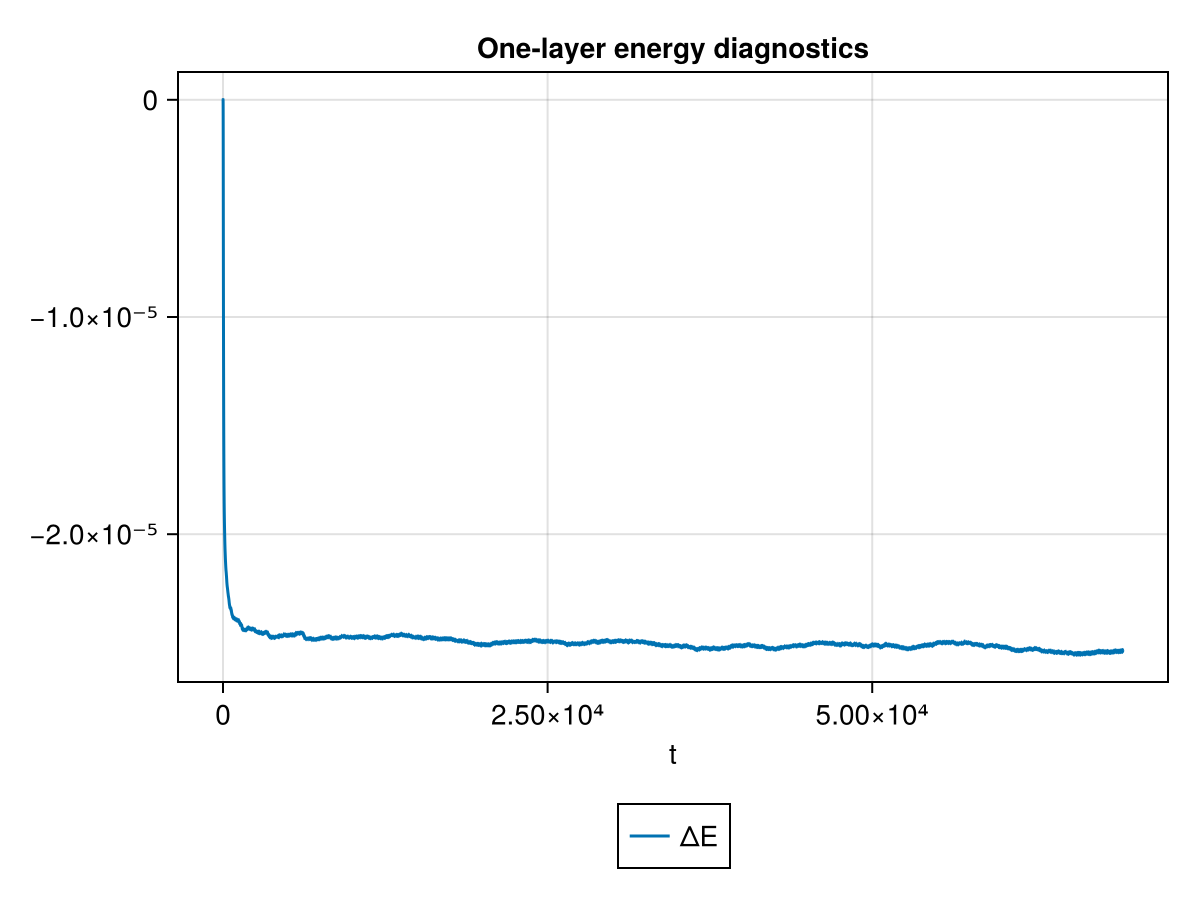

In [49]:
new_data_directory = "/scratch/nad9961/swqg/58628043/7/"
diag_file = jldopen(new_data_directory * "diagnostics.jld2")
t = diag_file["diagnostics/kinetic_energy/t"]
energy = diag_file["diagnostics/kinetic_energy/data"]
PE = diag_file["diagnostics/potential_energy/data"]
KE1 = map(x -> x, energy)
#KE2 = map(x -> x[2], energy)

fig = Figure()
ax = Axis(fig[1,1], xlabel="t", title="One-layer energy diagnostics")
lines!(ax, t, KE1 + PE .- KE1[1] .- PE[1], label="ΔE")
#lines!(ax, t, KE2, label="KE 2")
#lines!(ax, t, PE, label="PE")

Legend(fig[2,1], ax, orientation=:horizontal)
resize_to_layout!(fig)
fig

In [50]:
snapfile = jldopen(data_directory * "2Lqg.000001.jld2")
frames = keys(snapfile["snapshots/sol"])
sol1 = snapfile["snapshots/sol/" * frames[end-1]]
sol2 = snapfile["snapshots/sol/" * frames[end]]
using AbstractFFTs
q1 = irfft(sol1, 512, (1, 2))
q2 = irfft(sol2, 512, (1, 2))
fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
heatmap!(ax1, q1[:,:,1], colormap=:balance)
heatmap!(ax2, q2[:,:,1], colormap=:balance)

fig

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/pdSa4/src/JLD2.jl:152


LoadError: SystemError: opening file "/scratch/nad9961/swqg/60595660/2Lqg.000001.jld2": No such file or directory

In [51]:
println(fit.param)
println(fit_fd.param)
println(fit_fd_crazy.param)
time-t_offset

LoadError: type Nothing has no field param

In [52]:
f1 = Figure()
ax = Axis(f1[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers[nan_filter2], theo_fd_spectrum(bin_centers[nan_filter2], fit_fd.param))
lines!(ax, bin_centers[nan_filter2], radial_forced_action_spectrum[nan_filter2])
lines!(ax, bin_centers[nan_filter2], exp.(theo_action_spectrum(bin_centers[nan_filter2], fit_fd_crazy.param)))
f1

LoadError: UndefVarError: `nan_filter2` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [53]:
times = 0.01:0.1:15000
bin_counts = zeros(Nbins)
for ti=times
    bin_counts += theoretical_action_spectrum(bin_centers, k0, k_max, b, ti, f0, Cg) * 0.1
end

LoadError: UndefVarError: `b` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

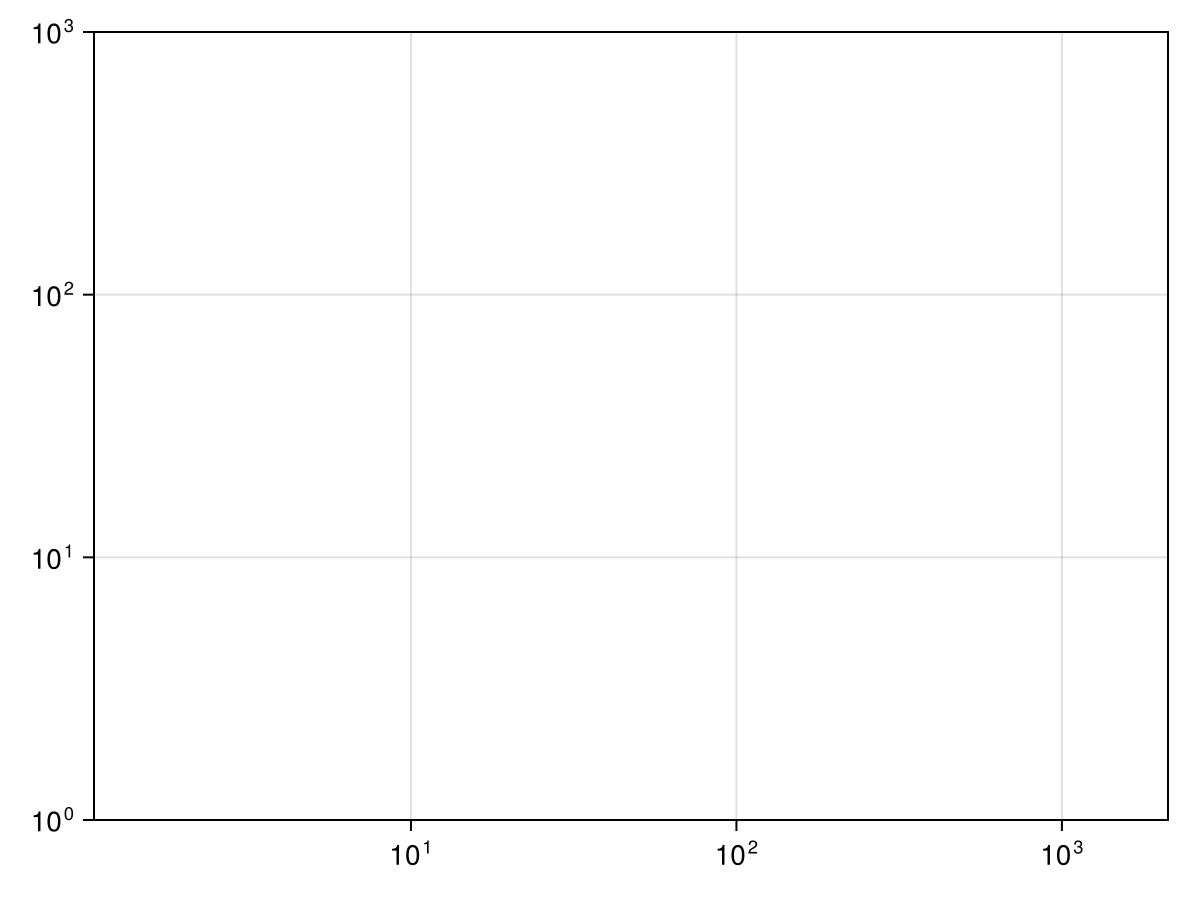

In [27]:
f = Figure()
ax = Axis(f[1,1]; xscale=log10, yscale=log10)
lines!(ax, bin_centers, bin_counts)
f

In [28]:
bin_counts1, time1 = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, Nsnapshots)
bin_counts2, time2 = snapshot_counts(run_directory, k_max, radial_transform_function, Nbins, index_function, Nsnapshots - 1)

LoadError: UndefVarError: `index_function` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [29]:
t, x, k, u = load_snapshot(run_directory, 1)

LoadError: IOError: readdir("/scratch/nad9961/swqg/60595660/1"): no such file or directory (ENOENT)

In [30]:
k

262144×2 Matrix{Float32}:
 NaN           NaN
  -2.80015f27    1.68397f27
 NaN           NaN
 NaN           NaN
   9.90056f34    2.25609f34
   1.27741f25    2.04346f25
   5.41927f29    5.97238f29
 NaN           NaN
   2.10249f27    1.46045f27
  -8.13325f34   -1.09896f35
  -1.31822f12   -1.57221f12
   1.4442f34    -5.54163f35
   5.06084f31    6.15621f30
   ⋮           
  -7.52411f29    1.08289f30
  -3.01051f29    4.38035f29
   2.42582f34    1.05767f34
 NaN           NaN
   2.17264f32   -1.86971f31
 NaN           NaN
   1.64309f35    1.14097f37
 NaN           NaN
 NaN           NaN
 NaN           NaN
  -1.43727f27    1.7659f27
  -2.25312f27    8.72756f26

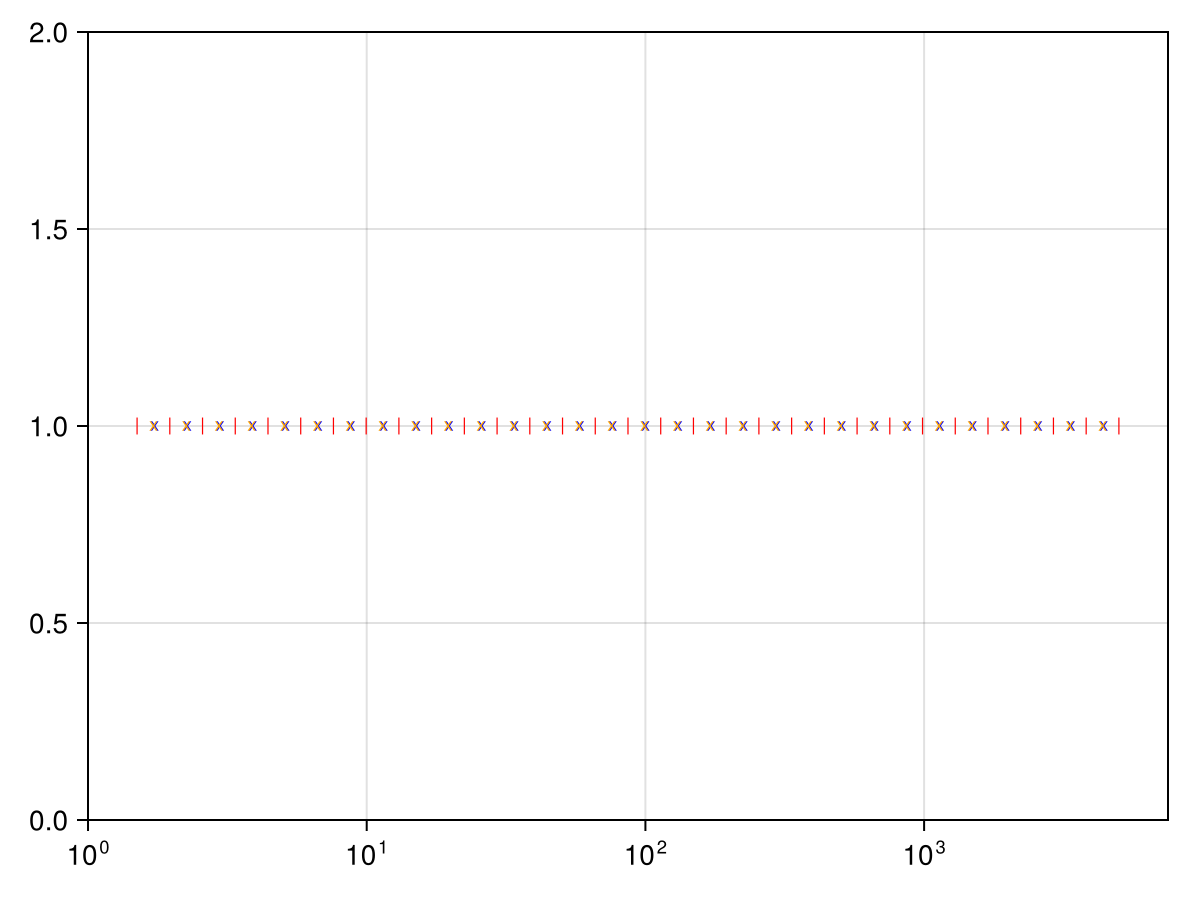

In [258]:
Nbins = 30
bin_edges = @. exp(log(ω_min) + (log(ω_max/ω_min)*(0:(Nbins))/(Nbins)))
bin_size = diff(exp.((0:(Nbins))/Nbins * log(ω_max / ω_min) ) * ω_min)
bin_centers1 = bin_edges[1:end-1] .+ 0.5*bin_size
bin_centers2 = @. sqrt(bin_edges[1:end-1] .* bin_edges[2:end])
ω_index_function(ω) = exponential_array_index(ω, ω_min, ω_max, Nbins)
K_index_function(ω) = exponential_array_index(k, k_min, k_max, Nbins)

fig = Figure()
ax = Axis(fig[1,1]; xscale=log10)
scatter!(ax, bin_edges, ones(Nbins+1), color=:red, marker='|')
scatter!(ax, bin_centers1, ones(Nbins), color=:blue, marker='x')
scatter!(ax, bin_centers2, ones(Nbins), color=:orange, marker='x')

fig

In [84]:
data_directory = "/scratch/nad9961/swqg/58025661/" # This matches the energetics of the two layer flow hopefully (Use run_idx = 20)
froudes = zeros(20)
froudes1 = zeros(20)
froudes2 = zeros(20)
mean_ωs = zeros(20)
for run_idx=1:20
    run_directory = data_directory * string(run_idx)
    f0, Cg = read_parameters(run_directory)
    Nsnapshots = count_snapshots(run_directory)
    Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
    t1, x, k, up = load_snapshot(run_directory, Nsnapshots)
    umax = 0
    for i=1:100:Nqg_snapshots
        t2, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, i)
        umax = max(umax, maximum(sqrt.(u.^2 + v.^2)))
    end
    t2, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
    umax_i = maximum(sqrt.(u.^2 + v.^2))
    ω = compute_ω(k, f0, Cg)
    mean_ω = mean(ω)
    println(umax / Cg)
    println(mean_ω)
    froudes[run_idx] = umax / Cg
    froudes1[run_idx] = umax_i / Cg
    mean_ωs[run_idx] = mean_ω
end

1.2476581388253867
109902.69659732495
1.1882459013054076
319.6790526393673
1.134234694706825
12.033188815268936
1.084920117203256
8.740595744994339
1.0397151544202294
7.469987543287511
0.9981265259335534
6.45295084255091
0.9597370793698246
5.92786686042948
0.9241911909921947
5.548776721778258
0.8911843943607635
5.259076792658888
0.8604539264261223
5.0080293568281045
0.8317720718929753
4.847489245187173
0.598875902611567
2.8882666190394373
0.6986885190038474
3.298658958919237
0.7985012133748555
3.9384321181648234
0.898313848872936
4.873075067174015
0.9981265259335534
6.45295084255091
1.097939158195512
5.564182231577139
1.197751805223134
96.68446657847441
1.2975644337267136
7.2897135617443665
1.3973770380076949
917825.4614559322


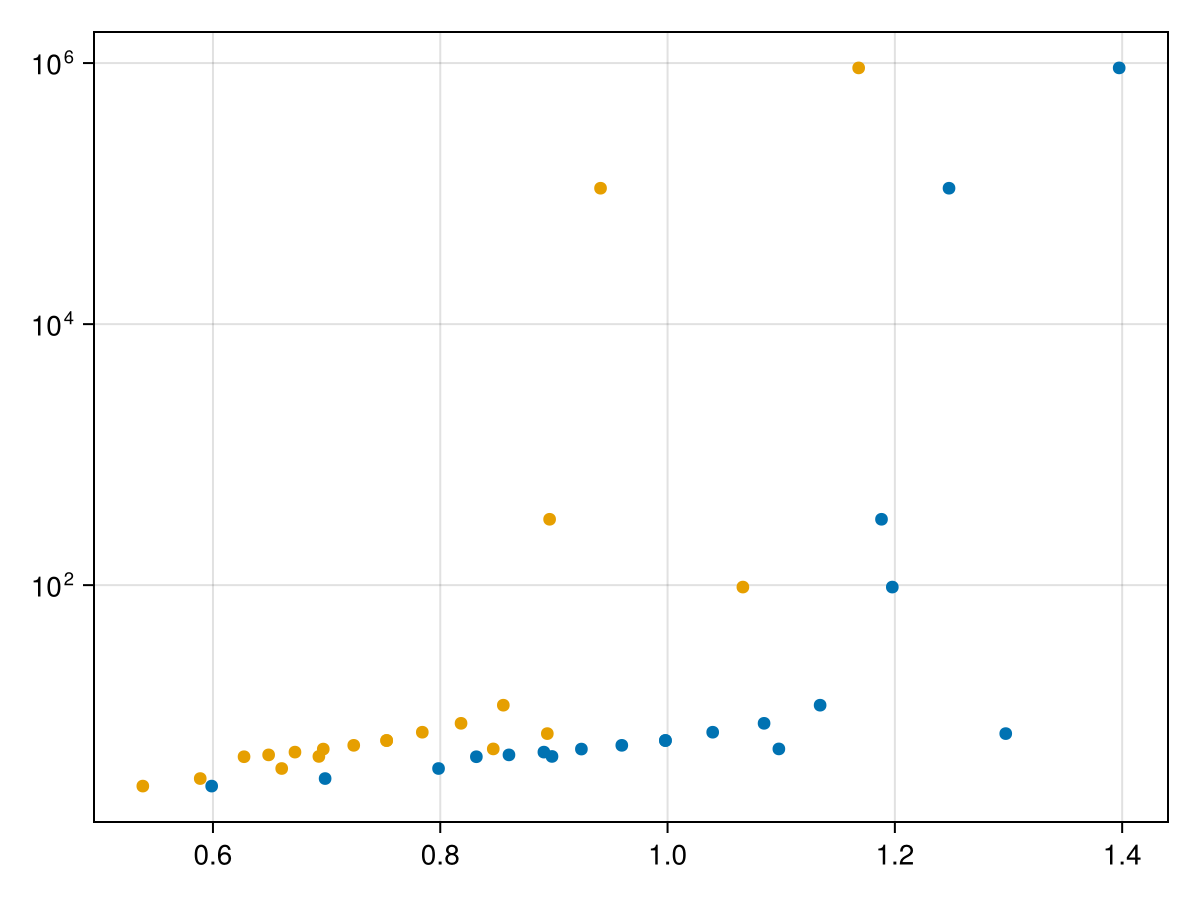

In [86]:
fig = Figure()
ax = Axis(fig[1,1]; yscale=log10)
scatter!(ax, froudes, mean_ωs)
scatter!(ax, froudes1, mean_ωs)

fig

In [11]:
data_directory = "/scratch/nad9961/swqg/64977428/" # This matches the energetics of the two layer flow hopefully (Use run_idx = 20)
N = 5
froudes = zeros(N)
froudes1 = zeros(N)
froudes2 = zeros(N)
mean_ωs = zeros(N)
for run_idx=1:N
    run_directory = data_directory * string(run_idx)
    f0, Cg = read_parameters(run_directory)
    Nsnapshots = count_snapshots(run_directory)
    Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
    t1, x, k, up = load_snapshot(run_directory, Nsnapshots)
    umax = 0
    for i=Nqg_snapshots:Nqg_snapshots
        t2, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, i)
        umax = max(umax, maximum(sqrt.(u.^2 + v.^2)))
    end
    t2, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
    umax_i = maximum(sqrt.(u.^2 + v.^2))
    ω = compute_ω(k, f0, Cg)
    mean_ω = mean(ω[isfinite.(ω)])
    println(umax / Cg)
    println(mean_ω)
    froudes[run_idx] = umax / Cg
    froudes1[run_idx] = umax_i / Cg
    mean_ωs[run_idx] = mean_ω
end

0.3763433162205265
4.496970774470732
0.613843925454564
16.803772407863114
0.7521555113883301
6.0231615740809215
0.888183163061739
5.728618468465259
1.1777033941222728
3.5008141708296316e13


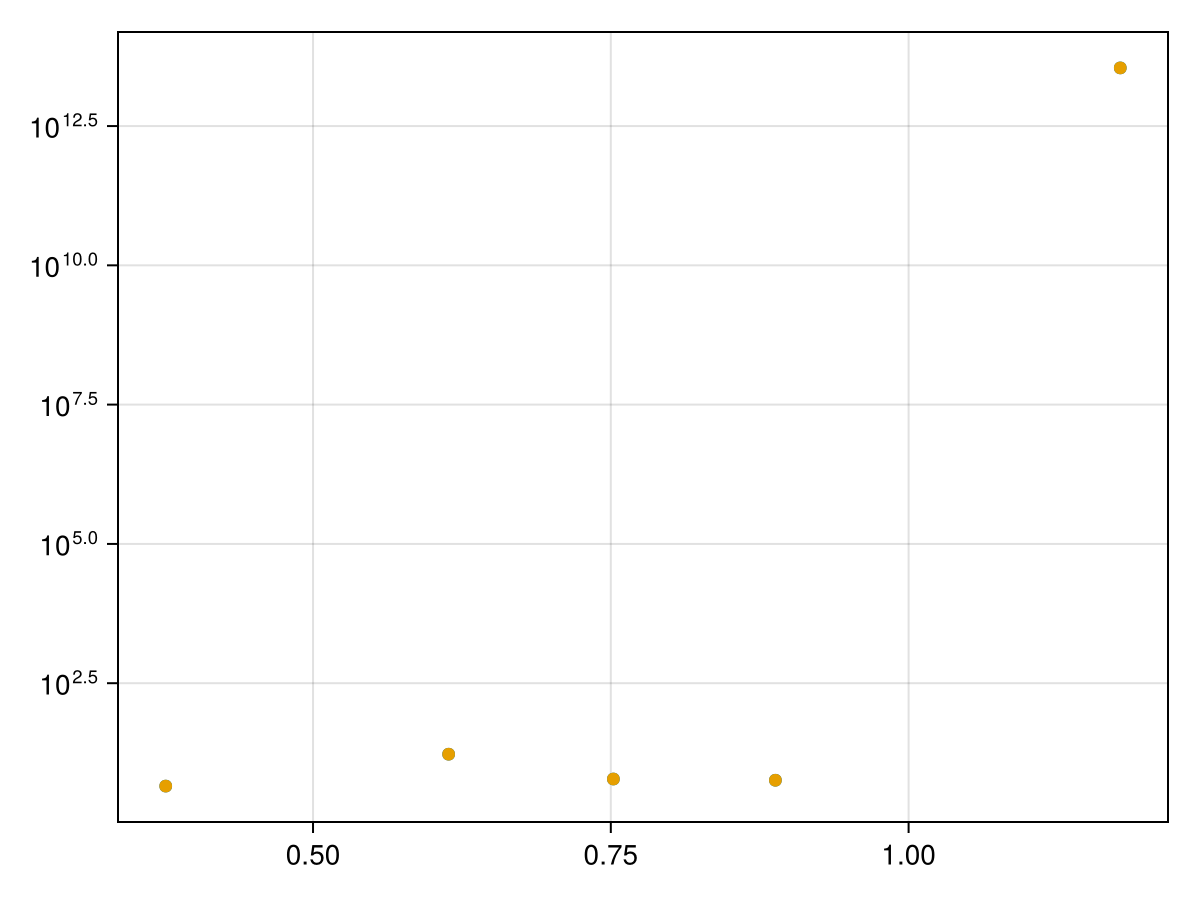

In [12]:
fig = Figure()
ax = Axis(fig[1,1]; yscale=log10)
scatter!(ax, froudes, mean_ωs)
scatter!(ax, froudes1, mean_ωs)

fig

In [56]:
t1, x, k, up = load_snapshot(run_directory, Nsnapshots)
findall(isnan.(k))

52-element Vector{CartesianIndex{2}}:
 CartesianIndex(4719, 1)
 CartesianIndex(5835, 1)
 CartesianIndex(7725, 1)
 CartesianIndex(7863, 1)
 CartesianIndex(10837, 1)
 CartesianIndex(15998, 1)
 CartesianIndex(18447, 1)
 CartesianIndex(19095, 1)
 CartesianIndex(19293, 1)
 CartesianIndex(19471, 1)
 CartesianIndex(33671, 1)
 CartesianIndex(33706, 1)
 CartesianIndex(34374, 1)
 ⋮
 CartesianIndex(38613, 2)
 CartesianIndex(43135, 2)
 CartesianIndex(43980, 2)
 CartesianIndex(46977, 2)
 CartesianIndex(48318, 2)
 CartesianIndex(51115, 2)
 CartesianIndex(51596, 2)
 CartesianIndex(53559, 2)
 CartesianIndex(53937, 2)
 CartesianIndex(56274, 2)
 CartesianIndex(56483, 2)
 CartesianIndex(62465, 2)

In [66]:
Npoints = 2
idx = [4719, 18447]
t_track = zeros(Nsnapshots, Npoints, 1)
x_track = zeros(Nsnapshots, Npoints, 2)
k_track = zeros(Nsnapshots, Npoints, 2)
u_track = zeros(Nsnapshots, Npoints, 2)
idx_filter = 2000:2200
for snap_idx = idx_filter
    t, x, k, u = load_snapshot(run_directory, snap_idx)
    t_track[snap_idx] = t
    @views x_track[snap_idx,:,:] = @views x[idx,:]
    @views k_track[snap_idx,:,:] = @views k[idx,:]
    @views u_track[snap_idx,:,:] = @views u[idx,:]
end

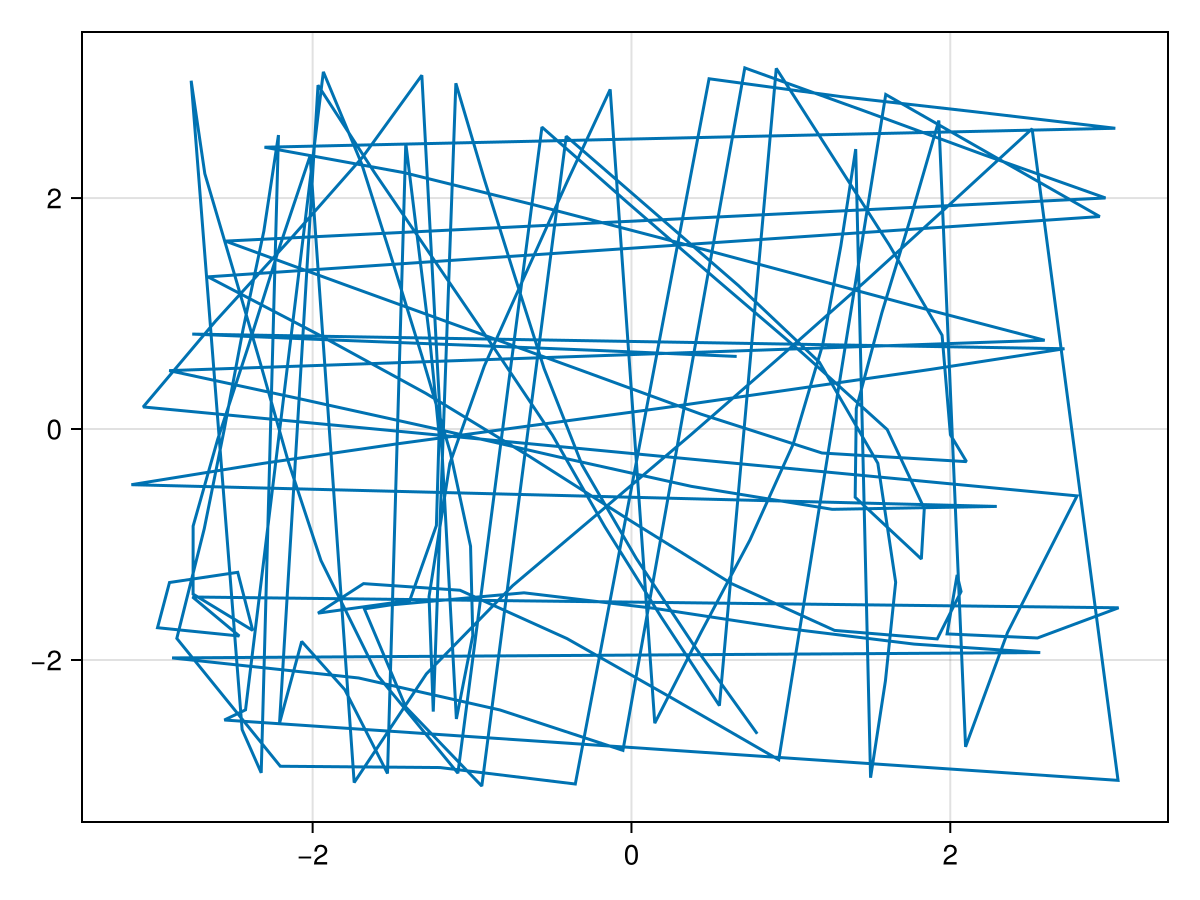

In [67]:
pt_idx = 2
x_track = @. mod(x_track + π, 2π) - π
lines(x_track[idx_filter,pt_idx,1], x_track[idx_filter,pt_idx,2])

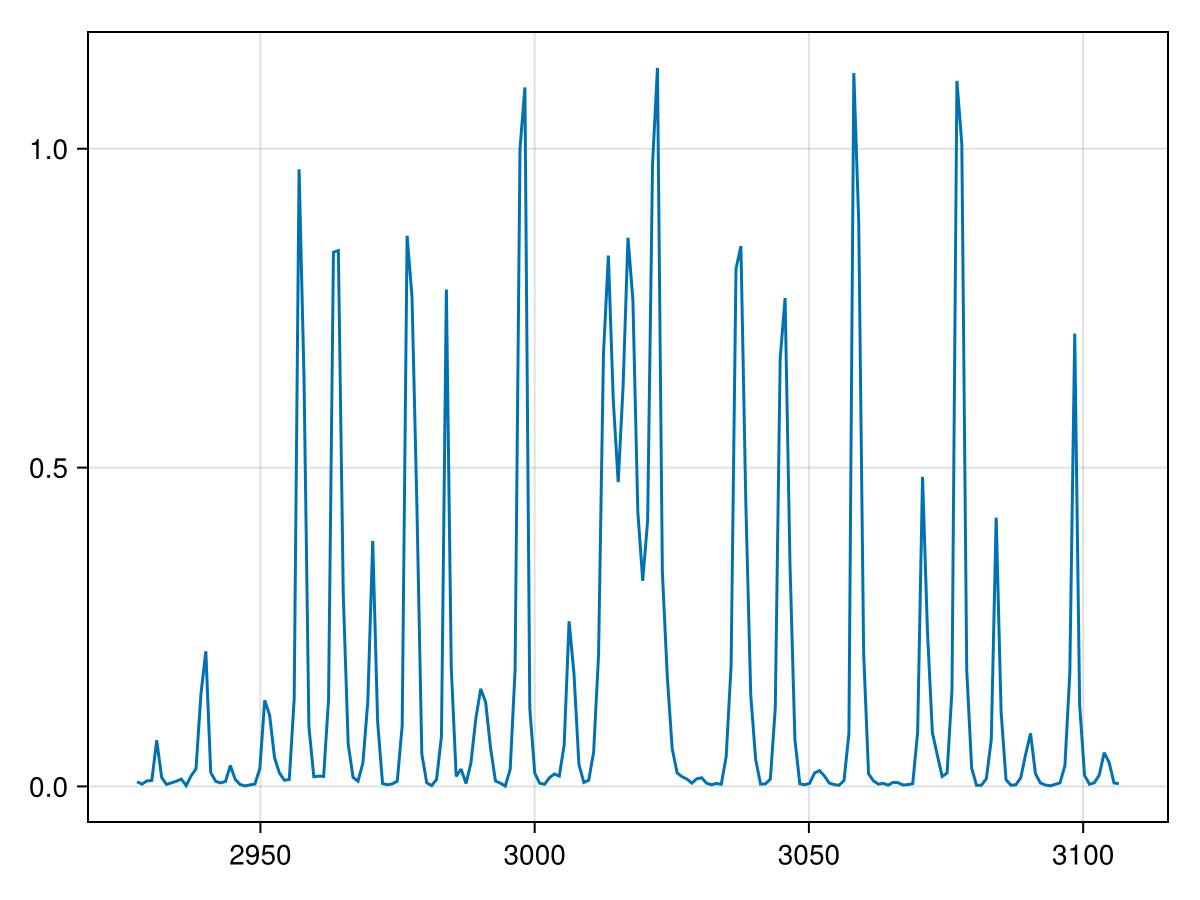

In [68]:
speed = sqrt.(u_track[idx_filter,pt_idx,1].^2 + u_track[idx_filter,pt_idx,2].^2)
lines(t_track[idx_filter], speed)

In [47]:
run_directory = "/scratch/nad9961/swqg/60112713/7"
filename_func(idx) = @sprintf("%s/%s.%06d.jld2", run_directory, "swqg", idx)
num_files = sum([1 for file in readdir(run_directory) if occursin(@sprintf("%s.", "swqg"), file)])-1
umax = 0
for j=0:num_files
    file = jldopen(filename_func(j))
    for key=keys(file["snapshots/t"])
        qh = file["snapshots/sol/" * key]
        ψh = -qh ./ (grid.Krsq .+ Kd2)
        uh = -1im * grid.l .* ψh
        vh =  1im * grid.kr .* ψh
        u = irfft(uh, grid.nx)
        v = irfft(vh, grid.nx)
        umax_temp = maximum(u.^2 + v.^2)
        if umax_temp > umax
            umax = umax_temp
            println(umax)
        end
    end
    close(file)
end


0.4881656465877897
0.5160135943060735
0.5895691963627449


In [48]:
println(umax)

0.5895691963627449
